<a href="https://colab.research.google.com/github/Arpit-Baranwal/Transformer_Implementation/blob/Vision_Transformers/DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import requests
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

DETR class definition

In [23]:
class DETRdemo(nn.Module):
  #num_classes = 91 predefined in coco dataset
  def __init__(self, num_classes = 91, hidden_dim = 256, nheads = 8, num_encoder_layers = 6, num_decoder_layer = 6):
    super().__init__()

    #resent backbone
    self.backbone = resnet50()
    del self.backbone.fc
    self.conv = nn.Conv2d(2048, hidden_dim, 1)
    #transformer wiuth encoder + decoder
    self.transformer = nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layer)
    #MLP for class and mlp for bbox
    self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
    self.linear_bbox = nn.Linear(hidden_dim, 4) #4 coordinates of the bounding box
    #position embedding for object queries
    self.query_pos = nn.Parameter(torch.rand(100, hidden_dim)) #there are total 100 queries

    # position embedding for image feature sequence
    self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2)) # any number greater than 42 will work because the feature matrix resent 50 output will have 2048 channels but height and width is 42,25
    self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2)) # any number greater than 25

  def forward(self,inputs):

    #forward pass through resnet
    x = self.backbone.conv1(inputs)
    x = self.backbone.bn1(x)
    x = self.backbone.relu(x)
    x = self.backbone.maxpool(x)

    x = self.backbone.layer1(x)
    x = self.backbone.layer2(x)
    x = self.backbone.layer3(x)
    x = self.backbone.layer4(x)
    # projecting from 2048 to 256 dimension
    h = self.conv(x)

    H,W = h.shape[-2:]
    pos = torch.cat([self.row_embed[:H].unsqueeze(1).repeat(1,W,1),
                     self.col_embed[:W].unsqueeze(0).repeat(H,1,1)],dim=-1).flatten(0,1).unsqueeze(1)

    #forward pass through transformer
    # we add the position embedding to the variable h
    h = self.transformer(pos + h.flatten(2).permute(2,0,1), self.query_pos.unsqueeze(1)).transpose(0,1)

    #forward pass through MLPs for classification and bbox prediction
    return {'pred_logits': self.linear_class(h),
            'pred_boxes': self.linear_bbox(h).sigmoid()}

Importing pre trained weights from facebook

In [24]:
detr =  DETRdemo()
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


DETRdemo(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

## COCO classes and bbox colors

In [10]:
#COCO classes
CLASSES = [
'N/A', 'person', 'bicycle','car', 'motorcycle', 'airplane', 'bus', 'train',
            'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
            'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
            'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
            'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee',
            'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
            'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
            'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
            'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
            'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv',
            'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
            'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
            'vase', 'scissors', 'teddy bear', 'hair dryer', 'toothbrush']

#colors for visualization
COLORS=[[0.000,0.447,0.741],[0.850,0.325,0.098],[0.929,0.694,0.125],
        [0.494,0.184,0.556],[0.466,0.674,0.188],[0.301,0.745,0.933]]

## Write a function to scale the bbox from 0-1 to image H, W

In [11]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

def box_cxcywh_to_xyxy(x):
  x_c,y_c,w,h = x.unbind(1)
  b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
       (x_c + 0.5 * w), (y_c + 0.5 * h)]
  return torch.stack(b,dim=1)

def resclae_bboxes(out_bbox,size):
  img_w, img_h = size
  b = box_cxcywh_to_xyxy(out_bbox)
  b = b * torch.tensor([img_w,img_h,img_w,img_h])
  return b

## Predict outputs and then scaling the boxes keeping only high confidence prediction

In [35]:
def detect(im,model,transform):
  img = transform(im).unsqueeze(0)
  outputs = model(img)

  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.5

  bboxes_scaled = resclae_bboxes(outputs['pred_boxes'][0,keep],im.size)
  return probas[keep],bboxes_scaled

## Upload an inference image for testing

In [36]:
url = 'https://media.istockphoto.com/id/1332455278/photo/smiling-white-light-brown-and-dark-brown-teddy-bears-sitting-on-table-at-pink-wall-background.jpg?s=612x612&w=0&k=20&c=vt3NvcLmXOFQQdbp_9_V3ZVlC1Dd47OFk4UEbgDd750='
im = Image.open(requests.get(url,stream=True).raw)
scores, boxes = detect(im,detr,transform)

## Plotting results

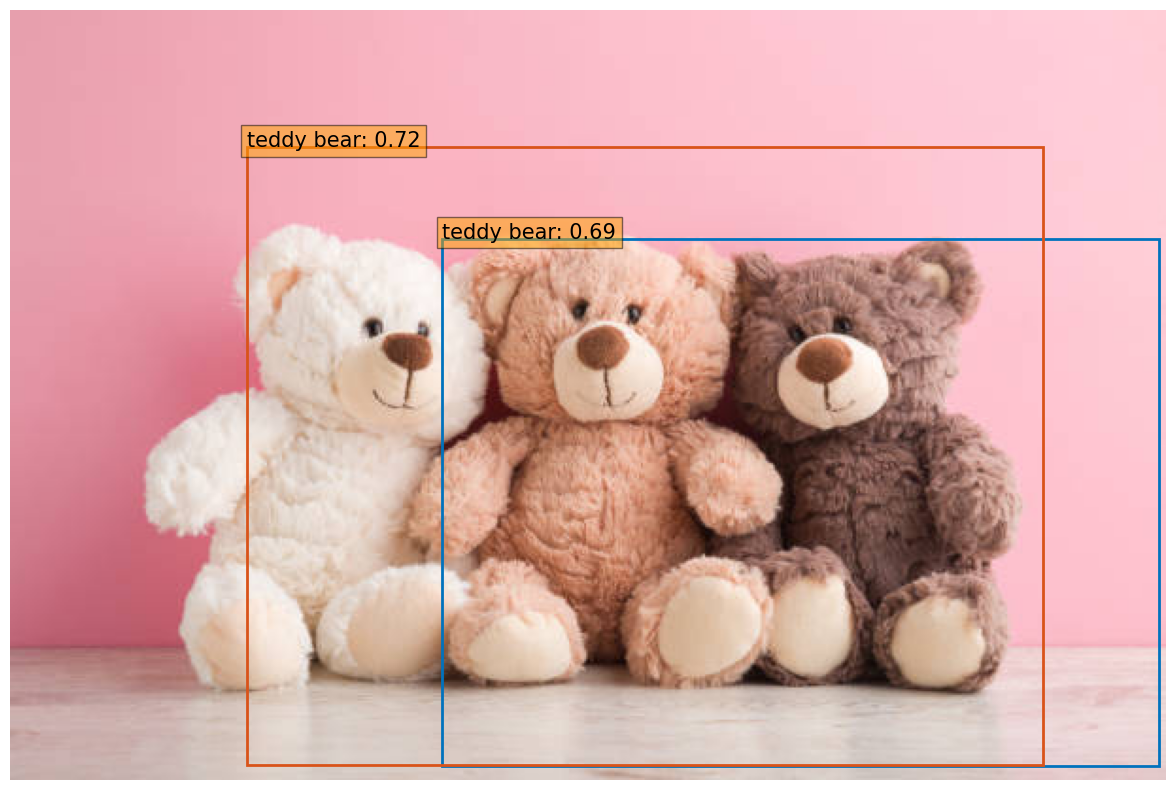

In [37]:
def plot_results(pil_img,scores,boxes):
  plt.figure(figsize=(16,10))
  plt.imshow(pil_img)
  ax = plt.gca()

  for p , (xmin,ymin,xmax,ymax),c in zip(scores,boxes.tolist(), COLORS * 100):
    ax.add_patch(plt.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,fill=False,color = c, linewidth = 2))
    cl = p.argmax()
    text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
    ax.text(xmin,ymin,text,fontsize = 15,bbox = dict(facecolor='orange',alpha=0.5))

  plt.axis('off')
  plt.show()

plot_results(im,scores,boxes)
